In [340]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd
import xlsxwriter

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [341]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
Eff = Data.sheet_by_name('Eff')


Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)
Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

In [342]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Cold')

m_f_HEx_c   = array(HEx.col_values(0)) 
Ec_HEx_c   = array(HEx.col_values(1)) 
W_T_HEx_c   = array(HEx.col_values(2)) 
W_f_HEx_c   = array(HEx.col_values(3)) 
W_p_HEx_c   = array(HEx.col_values(4)) 

In [343]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Hot')

m_f_HEx_h   = array(HEx.col_values(0)) 
Ec_HEx_h   = array(HEx.col_values(1)) 
W_T_HEx_h   = array(HEx.col_values(2)) 
W_f_HEx_h   = array(HEx.col_values(3)) 
W_p_HEx_h   = array(HEx.col_values(4)) 

def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    for i in range(A,B):
        print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[C]) and ECr < Ec_HEx[i]:
            C = i
            #print('oic',C)
    for i in range(B,A,-1):
        print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[D]) and ECr > Ec_HEx[i]:
            D = i
            #print('oid',D)
    print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [344]:
def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    #print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    #print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    Ref_C = 1
    Ref_D = 0
    for i in range(A,B):
        #print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ref_C) and ECr < Ref_C:
            C = i
            Ref_C = Ec_HEx[i]
            #print('oic',C)
    for i in range(B,A,-1):
        #print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ref_D) and ECr > Ref_D:
            D = i
            Ref_D = Ec_HEx[i]
            #print('oid',D)
    #print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [345]:
def Radius(X): 
    R2,R3,B,L_m,L_r = X
    #return (1.41634776*(R2**-1.10684344)*(R3**2.08169412)*(B**0.74232364))
    #return((B/((0.7390256*R2**1.49668268*R3**-2.71694101)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.23379933))
    return((B/((0.74794602381*R2**1.50307868*R3**-2.73422634)*1.025343*np.exp(-33.1224/L_m)*(-6.66110174/32*(L_r/L_m)**3 + 2.67069441/12*(L_r/L_m)**2 - 0.50770413/4*(L_r/L_m) + 1.00892496)))**(1/1.240075))

In [346]:
Radius((150,180,1,300,150))

298.85591336001306

In [347]:
def Qc(X): 
    P1,P2,P3,P4,P5= X #Q_pas_CB,Q_act_CB,Q_span,W_mag,W_p
    #return (0.5124256*P1+0.573295*P2-0.52893772*P3-0.00821663*P4-1.2800057*P5)
    #return(0.46851473*P1 + 0.64301304*P2 -0.48044966*P3+0.02032531*P4 -P5)
    return(0.38587129*P1+0.64294648*P2-0.40428582*P3-0.01662812*P4-P5)

In [348]:
def Qh(X): 
    P1,P2,P3,P4,P5= X
    #return (0.7308924*P1+1.31973655*P2-0.7599739*P3+0.01339801*P4-0.85528785*P5)
    #return(0.98097574*P1+1.15711871*P2-0.98056457*P3+0.02958954*P4+P5)
    return(1.04758335*P1+1.20415137*P2-1.04778779*P3+0.03265983*P4+P5)  

In [349]:
def W_Hex(X):
    P1,P2 = X
    return (a*P1**b + c*P2**d)

In [350]:
def Prop_param(X):
    T_c,T_h,B = X
    C_H = 1.65161038/100*T_c+2.59946197*T_h-1.14324309*100*B
    C_L = 10.16443738*T_c-5.32568341*T_h-0.71305997*B
    dT_mg = -0.01057708*T_c+0.01163704*T_h+1.73509682*B
    dT_dmg = -0.01229483*T_c+0.01376157*T_h+0.76454655*B
    CdT_mg = -9.517569*T_c+11.49711993*T_h+820.04168503*B
    CdT_dmg = 4.39480124*T_c-7.07931118/10*T_h+9.15928168*100*B
    return(C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg)

In [351]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3))+273.15 #Import temperature span [K]
T_h = array(Inputs.col_values(4))+273.15 #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7))/3600 #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]
T_c_ml = array(Inputs.col_values(12))+273.15 #Import temperature span [K]
T_h_ml = array(Inputs.col_values(13))+273.15 #Import temperature span [K]

Calculation

In [352]:
def Optimal(m_f,FE,f,L,H,W,B,Tc,Th,Tce,The,L_xt):
    
    ##Properties of the solid 
    rho_s = 7900  #[kg/m3] Density of the solid
    k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

    ## Propertis of the fluid
    rho_f = 1000  #[kg/m3] Density of the fluid
    c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
    Pr_f  = 6.136 #[-] Prandtl of the fluid
    mu_f  = 0.00061 #0.0008901 #[kg/m-2] #Viscosity of the fluid
    k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

    ## Porous medium
    d_p = 500*10**(-6) #[m] Particle diameter
   
    Epsilon = 0.45 #0.55  #[-] Porosity
    Epsilon_dp = 0.36 #0.465 #[-] Porosity
    d_ph = (2/3)*Epsilon_dp/(1-Epsilon_dp)*d_p #290*10**(-6) #[m] Particle diameter
        
    #Magnetic Circuit
    B_rem = 1.43
    N_p = 2
    N_Rp = 2
    
    ### CALCULATION ###
    
    #Porous medium
    m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
    Beta = (1-Epsilon)*6/d_p
    v_s   = (m_f)/(rho_f*W*H*10**-6) #Superficial velocity

    #Dimensionless Numbers
    Re_dp = d_p*v_s*rho_f/(mu_f) #Reynolds number
    Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
    Pe = Re_dp*Pr_f
    h_int = Nu*k_f/d_p
    NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f*c_f) 
    #dP = (L/1000)*(150*(1-Epsilon_dp)**2*mu_f*v_s/(Epsilon_dp**3*d_p**2) + 1.75*(1-Epsilon_dp)*rho_f*v_s**2/(Epsilon_dp**3*d_p))
    
    dP = 0.5*413.11*(v_s*d_ph*rho_f/mu_f)**-0.514*rho_f*v_s**2*(L/1000)/d_ph
    #print(dP/dP_1)
    
    #Effective conduction
    k_e_f = k_f*Epsilon #Fluid effective conduction

    a_0 = exp(-1.084-6.778*(Epsilon-0.298))
    f_0 = 0.8
    k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

    D_ = (k_f*rho_f/c_f)*0.75*Pe/2

    k_s_eff = k_e_s
    k_f_eff = k_e_f + rho_f*c_f*D_
    
    ##### Properties Calculation ######   
    C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg = Prop_param((Tce,The,B))

    ##### Porous media effectivness #####

    C_HB = ((m_f)*c_f)/(m_s*C_L*f)
    C_CB = ((m_f)*c_f)/(m_s*C_H*f)

    Efness_HB = Effectiv(C_HB/2,NTU_f)
    Efness_CB = Effectiv(C_CB/2,NTU_f)

    #print(Efness_HB,Efness_CB,h_int,Nu,v_s,Re_dp)


    ## Metrics ##

    Q_pas_CB = Efness_CB*(The - Tce)*m_f*FE*c_f
    Q_act_CB = dT_mg*m_f*c_f*FE

    Q_pas_HB = Efness_HB*(The - Tce)*m_f*FE*c_f
    Q_act_HB = dT_dmg*m_f*c_f*FE

    Q_span = (The - Tce)*m_f*c_f*FE
    Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(The-Tce)/L
    W_mag  = m_s*f*(CdT_mg - CdT_dmg)
    W_pump = dP*m_f/rho_f*2*(FE)
    #print(Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump)

    ######Calculation#######
    
    N_reg = 4/FE
    
    R2 = [W/2+2.5]/np.tan(np.pi/N_reg)
    R_aux = np.sqrt(R2**2-(W/2**2))
    R3 = np.sqrt((H+8+R_aux)**2+(W/2)**2)
    
    FL = (0.45238549*(1+L_xt)**3-2.34797947*(1+L_xt)**2 +4.06737728*(1+L_xt)-1.44601011)*R2**-0.14716104*R3**(0.15172723)
    
    Qc_reg = Qc((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump))*FL
    Qh_reg = Qh((Q_pas_HB,Q_act_HB,Q_span,W_mag,W_pump))*FL
    #print(Qc_reg,Qh_reg)
    #N_reg = Qc_target/Qc_reg
    Qc_target = Qc_reg*N_reg 
    Qh_target = Qh_reg*N_reg

    ECr_c = Qc_target/(FE*N_reg*m_f*c_f*(Tc-Tce))
    ECr_h = Qh_target/(FE*N_reg*m_f*c_f*(The-Th))
    
    B_rem = 1.43
    

    R4 = Radius((R2,R3,B/B_rem,L*(1+L_xt),L))
    
    W_mag = Qh_reg - Qc_reg - W_pump
    
    
    return (Qc_target,ECr_c,ECr_h,R4,R3,R2,W_mag,W_pump,Qh_target,L_xt,FL)

Qc_rg = []
Qh_rg = []
W_pump_rg =[]
ECr_c = []
ECr_h = []
N_r = []
R2 = []
R3 = []
R4 = []

for i in range(len(L)):                          
    A1,A2,A3,A4,A5,A6,A7,A8,A9 = Optimal(m_f[i],0.25,f[i],L[i],H[i],W[i],B[i],22+273.15,35+273.15,T_c[i],T_h[i])
    Qc_rg.append(A1)
    Qh_rg.append(A9)
    W_pump_rg.append(A8)
    ECr_c.append(A2)
    ECr_h.append(A3)
    N_r.append(A6)
    R2.append(A6)
    R3.append(A5)
    R4.append(A4)

ValueError: x and y must have same first dimension, but have shapes (216,) and (28,)

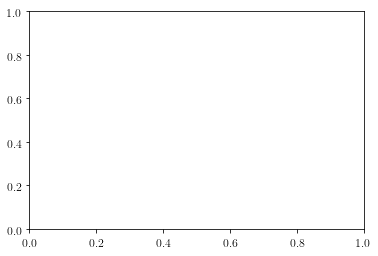

In [353]:
plt.plot(W_p,m_p,'o')

In [310]:
L

array([100, 105, 110, 115, 120, 125])

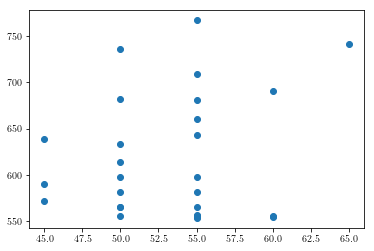

In [336]:
plt.plot(W_p,m_p,'o')

In [354]:
m_f = np.arange(400,1001,5)/3600
FE  = np.arange(25/100,30/100,5/100) 
f = np.arange(1.5,1.7,0.5)
L = np.arange(100,151,2.5)
H = np.arange(30,70,2.5)
W = np.arange(30,80,2.5)
B_max = np.arange(1,1.46,0.02)
Tce = np.arange(12,15,1)
The = np.arange(39,43,1)
L_xt = np.arange(0.1,0.7,0.1)

m_f = np.arange(800,801,5)/3600
FE  = np.arange(25/100,30/100,5/100) 
f = np.arange(1.5,1.9,0.5)
L = np.arange(150,159,10)
H = np.arange(50,51,5)
W = np.arange(60,61,5)
B_max = np.arange(1.3,1.34,0.05)
Tce = np.arange(14,15,2)
The = np.arange(42,43,2)
L_xt = np.arange(0.5,0.6,0.2)

In [355]:
len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)*len(L_xt)

3600

m_f = 600/3600
FE = 0.25
f = 2.25
L = 140
H = 20
W = 60
B_max = 1.5
T_c  = 22
T_h = 35
Tce = 14
The = 43

A = Optimal(m_f,FE,f,L,H,W,B_max,T_c+273.15,T_h+273.15,Tce+273.15,The+273.15,L_xt)
A[0][0]/16

In [356]:
Q_c = []
cont = 0

T_c = 22
T_h = 35

Q_c_target = 2900

m_f_target = []
FE_target = []
f_target = []
L_target = []
H_target = []
W_target = []
Tce_target = []
The_target = []
ECr_c = []
ECr_h = []
R4 = []
R3 = []
R2 = []
W_mag = []
W_pump = []
B_target = []
Q_h = []
L_xt_target = []
FL_target = []


for i in range(size(FE)):
    for j in range(len(f)):
        for k in range(len(L)):
            for l in range(len(H)):
                for m in range(len(W)):
                    for n in range(len(Tce)):
                        for o in range(len(The)):
                            for p in range(len(B_max)):
                                for q in range(len(L_xt)):
                                    it = 0
                                    Q_c_system = 0
                                    while Q_c_system < Q_c_target and it < len(m_f):
                                        A,B,C,D,E,F,G,A1,A2,A3,A4 = Optimal(m_f[it],FE[i],f[j],L[k],H[l],W[m],B_max[p],T_c+273.15,T_h+273.15,Tce[n]+273.15,The[o]+273.15,L_xt[q])
                                        Q_c_system = A[0]
                                        it = it + 1
                                        #print(A,B,C,D,E,F,G,A1,A2,A3)
                                        #print(m_f[it-1]*3600,Q_c_system )
                                    #print(it,Q_c_system)
                                    if Q_c_system > Q_c_target:
                                        Q_c.append(Q_c_system)
                                        m_f_target.append(3600*m_f[it-1])
                                        FE_target.append(FE[i])
                                        f_target.append(f[j])
                                        L_target.append(L[k])
                                        H_target.append(H[l])
                                        W_target.append(W[m])
                                        Tce_target.append(Tce[n])
                                        The_target.append(The[o])
                                        B_target.append(B_max[p])
                                        ECr_c.append(B[0])
                                        ECr_h.append(C[0])
                                        R4.append(D[0])
                                        R3.append(E[0])
                                        R2.append(F[0])
                                        W_mag.append(G[0])
                                        W_pump.append(A1)
                                        Q_h.append(A2[0])
                                        L_xt_target.append(A3)
                                        FL_target.append(A4)

                                    cont = cont+1
                                    print(100*cont/(len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)*len(L_xt)))
                            

0.027777777777777776
0.05555555555555555
0.08333333333333333
0.1111111111111111
0.1388888888888889
0.16666666666666666
0.19444444444444445
0.2222222222222222
0.25
0.2777777777777778
0.3055555555555556
0.3333333333333333
0.3611111111111111
0.3888888888888889
0.4166666666666667
0.4444444444444444
0.4722222222222222
0.5
0.5277777777777778
0.5555555555555556
0.5833333333333334
0.6111111111111112
0.6388888888888888
0.6666666666666666
0.6944444444444444
0.7222222222222222
0.75
0.7777777777777778
0.8055555555555556
0.8333333333333334
0.8611111111111112
0.8888888888888888
0.9166666666666666
0.9444444444444444
0.9722222222222222
1.0
1.0277777777777777
1.0555555555555556
1.0833333333333333
1.1111111111111112
1.1388888888888888
1.1666666666666667
1.1944444444444444
1.2222222222222223
1.25
1.2777777777777777
1.3055555555555556
1.3333333333333333
1.3611111111111112
1.3888888888888888
1.4166666666666667
1.4444444444444444
1.4722222222222223
1.5
1.5277777777777777
1.5555555555555556
1.583333333333333

13.88888888888889
13.916666666666666
13.944444444444445
13.972222222222221
14.0
14.027777777777779
14.055555555555555
14.083333333333334
14.11111111111111
14.13888888888889
14.166666666666666
14.194444444444445
14.222222222222221
14.25
14.277777777777779
14.305555555555555
14.333333333333334
14.36111111111111
14.38888888888889
14.416666666666666
14.444444444444445
14.472222222222221
14.5
14.527777777777779
14.555555555555555
14.583333333333334
14.61111111111111
14.63888888888889
14.666666666666666
14.694444444444445
14.722222222222221
14.75
14.777777777777779
14.805555555555555
14.833333333333334
14.86111111111111
14.88888888888889
14.916666666666666
14.944444444444445
14.972222222222221
15.0
15.027777777777779
15.055555555555555
15.083333333333334
15.11111111111111
15.13888888888889
15.166666666666666
15.194444444444445
15.222222222222221
15.25
15.277777777777779
15.305555555555555
15.333333333333334
15.36111111111111
15.38888888888889
15.416666666666666
15.444444444444445
15.47222222

27.333333333333332
27.36111111111111
27.38888888888889
27.416666666666668
27.444444444444443
27.47222222222222
27.5
27.52777777777778
27.555555555555557
27.583333333333332
27.61111111111111
27.63888888888889
27.666666666666668
27.694444444444443
27.72222222222222
27.75
27.77777777777778
27.805555555555557
27.833333333333332
27.86111111111111
27.88888888888889
27.916666666666668
27.944444444444443
27.97222222222222
28.0
28.02777777777778
28.055555555555557
28.083333333333332
28.11111111111111
28.13888888888889
28.166666666666668
28.194444444444443
28.22222222222222
28.25
28.27777777777778
28.305555555555557
28.333333333333332
28.36111111111111
28.38888888888889
28.416666666666668
28.444444444444443
28.47222222222222
28.5
28.52777777777778
28.555555555555557
28.583333333333332
28.61111111111111
28.63888888888889
28.666666666666668
28.694444444444443
28.72222222222222
28.75
28.77777777777778
28.805555555555557
28.833333333333332
28.86111111111111
28.88888888888889
28.916666666666668
28.94

40.861111111111114
40.888888888888886
40.916666666666664
40.94444444444444
40.97222222222222
41.0
41.02777777777778
41.05555555555556
41.083333333333336
41.111111111111114
41.138888888888886
41.166666666666664
41.19444444444444
41.22222222222222
41.25
41.27777777777778
41.30555555555556
41.333333333333336
41.361111111111114
41.388888888888886
41.416666666666664
41.44444444444444
41.47222222222222
41.5
41.52777777777778
41.55555555555556
41.583333333333336
41.611111111111114
41.638888888888886
41.666666666666664
41.69444444444444
41.72222222222222
41.75
41.77777777777778
41.80555555555556
41.833333333333336
41.861111111111114
41.888888888888886
41.916666666666664
41.94444444444444
41.97222222222222
42.0
42.02777777777778
42.05555555555556
42.083333333333336
42.111111111111114
42.138888888888886
42.166666666666664
42.19444444444444
42.22222222222222
42.25
42.27777777777778
42.30555555555556
42.333333333333336
42.361111111111114
42.388888888888886
42.416666666666664
42.44444444444444
42.4

54.47222222222222
54.5
54.52777777777778
54.55555555555556
54.583333333333336
54.611111111111114
54.638888888888886
54.666666666666664
54.69444444444444
54.72222222222222
54.75
54.77777777777778
54.80555555555556
54.833333333333336
54.861111111111114
54.888888888888886
54.916666666666664
54.94444444444444
54.97222222222222
55.0
55.02777777777778
55.05555555555556
55.083333333333336
55.111111111111114
55.138888888888886
55.166666666666664
55.19444444444444
55.22222222222222
55.25
55.27777777777778
55.30555555555556
55.333333333333336
55.361111111111114
55.388888888888886
55.416666666666664
55.44444444444444
55.47222222222222
55.5
55.52777777777778
55.55555555555556
55.583333333333336
55.611111111111114
55.638888888888886
55.666666666666664
55.69444444444444
55.72222222222222
55.75
55.77777777777778
55.80555555555556
55.833333333333336
55.861111111111114
55.888888888888886
55.916666666666664
55.94444444444444
55.97222222222222
56.0
56.02777777777778
56.05555555555556
56.083333333333336
5

67.97222222222223
68.0
68.02777777777777
68.05555555555556
68.08333333333333
68.11111111111111
68.13888888888889
68.16666666666667
68.19444444444444
68.22222222222223
68.25
68.27777777777777
68.30555555555556
68.33333333333333
68.36111111111111
68.38888888888889
68.41666666666667
68.44444444444444
68.47222222222223
68.5
68.52777777777777
68.55555555555556
68.58333333333333
68.61111111111111
68.63888888888889
68.66666666666667
68.69444444444444
68.72222222222223
68.75
68.77777777777777
68.80555555555556
68.83333333333333
68.86111111111111
68.88888888888889
68.91666666666667
68.94444444444444
68.97222222222223
69.0
69.02777777777777
69.05555555555556
69.08333333333333
69.11111111111111
69.13888888888889
69.16666666666667
69.19444444444444
69.22222222222223
69.25
69.27777777777777
69.30555555555556
69.33333333333333
69.36111111111111
69.38888888888889
69.41666666666667
69.44444444444444
69.47222222222223
69.5
69.52777777777777
69.55555555555556
69.58333333333333
69.61111111111111
69.63888

81.94444444444444
81.97222222222223
82.0
82.02777777777777
82.05555555555556
82.08333333333333
82.11111111111111
82.13888888888889
82.16666666666667
82.19444444444444
82.22222222222223
82.25
82.27777777777777
82.30555555555556
82.33333333333333
82.36111111111111
82.38888888888889
82.41666666666667
82.44444444444444
82.47222222222223
82.5
82.52777777777777
82.55555555555556
82.58333333333333
82.61111111111111
82.63888888888889
82.66666666666667
82.69444444444444
82.72222222222223
82.75
82.77777777777777
82.80555555555556
82.83333333333333
82.86111111111111
82.88888888888889
82.91666666666667
82.94444444444444
82.97222222222223
83.0
83.02777777777777
83.05555555555556
83.08333333333333
83.11111111111111
83.13888888888889
83.16666666666667
83.19444444444444
83.22222222222223
83.25
83.27777777777777
83.30555555555556
83.33333333333333
83.36111111111111
83.38888888888889
83.41666666666667
83.44444444444444
83.47222222222223
83.5
83.52777777777777
83.55555555555556
83.58333333333333
83.61111

96.11111111111111
96.13888888888889
96.16666666666667
96.19444444444444
96.22222222222223
96.25
96.27777777777777
96.30555555555556
96.33333333333333
96.36111111111111
96.38888888888889
96.41666666666667
96.44444444444444
96.47222222222223
96.5
96.52777777777777
96.55555555555556
96.58333333333333
96.61111111111111
96.63888888888889
96.66666666666667
96.69444444444444
96.72222222222223
96.75
96.77777777777777
96.80555555555556
96.83333333333333
96.86111111111111
96.88888888888889
96.91666666666667
96.94444444444444
96.97222222222223
97.0
97.02777777777777
97.05555555555556
97.08333333333333
97.11111111111111
97.13888888888889
97.16666666666667
97.19444444444444
97.22222222222223
97.25
97.27777777777777
97.30555555555556
97.33333333333333
97.36111111111111
97.38888888888889
97.41666666666667
97.44444444444444
97.47222222222223
97.5
97.52777777777777
97.55555555555556
97.58333333333333
97.61111111111111
97.63888888888889
97.66666666666667
97.69444444444444
97.72222222222223
97.75
97.7777

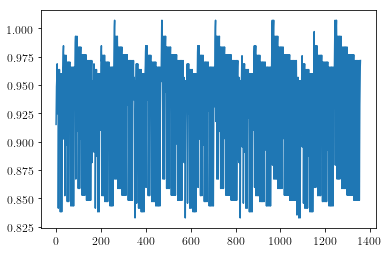

In [357]:
plt.plot(FL_target)

In [358]:
N_circ_cold = 6
N_circ_hot = 8

W_FT_c = np.zeros(len(m_f_target))
W_Ff_c = np.zeros(len(m_f_target))
W_Fp_c = np.zeros(len(m_f_target))

W_FT_h = np.zeros(len(m_f_target))
W_Ff_h = np.zeros(len(m_f_target))
W_Fp_h = np.zeros(len(m_f_target))


for i in range(len(m_f_target)):
    print(i/len(m_f_target))
    [W_FT_c[i],W_Ff_c[i],W_Fp_c[i]] = HEx_Power(m_f_HEx_c,W_T_HEx_c,W_f_HEx_c,W_p_HEx_c,Ec_HEx_c,4*m_f_target[i]/N_circ_cold,ECr_c[i])
    [W_FT_h[i],W_Ff_h[i],W_Fp_h[i]] = HEx_Power(m_f_HEx_h,W_T_HEx_h,W_f_HEx_h,W_p_HEx_h,Ec_HEx_h,4*m_f_target[i]/N_circ_hot,ECr_h[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_c[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_h[i])

0.0
0.0007363770250368188
0.0014727540500736377
0.0022091310751104565
0.0029455081001472753
0.003681885125184094
0.004418262150220913
0.005154639175257732
0.005891016200294551
0.0066273932253313695
0.007363770250368188
0.008100147275405008
0.008836524300441826
0.009572901325478646
0.010309278350515464
0.011045655375552283
0.011782032400589101
0.012518409425625921
0.013254786450662739
0.013991163475699559
0.014727540500736377
0.015463917525773196
0.016200294550810016
0.016936671575846832
0.017673048600883652
0.018409425625920472
0.01914580265095729
0.019882179675994108
0.020618556701030927
0.021354933726067747
0.022091310751104567
0.022827687776141383
0.023564064801178203
0.024300441826215022
0.025036818851251842
0.02577319587628866
0.026509572901325478
0.027245949926362298
0.027982326951399118
0.028718703976435934
0.029455081001472753
0.030191458026509573
0.030927835051546393
0.03166421207658321
0.03240058910162003
0.03313696612665685
0.033873343151693665
0.03460972017673049
0.03534609

0.31001472754050075
0.31075110456553756
0.3114874815905744
0.3122238586156112
0.312960235640648
0.3136966126656848
0.31443298969072164
0.31516936671575846
0.3159057437407953
0.3166421207658321
0.3173784977908689
0.3181148748159057
0.31885125184094254
0.31958762886597936
0.32032400589101623
0.32106038291605304
0.32179675994108986
0.3225331369661267
0.3232695139911635
0.3240058910162003
0.3247422680412371
0.32547864506627394
0.32621502209131076
0.3269513991163476
0.3276877761413844
0.3284241531664212
0.329160530191458
0.32989690721649484
0.33063328424153166
0.33136966126656847
0.3321060382916053
0.3328424153166421
0.3335787923416789
0.33431516936671574
0.33505154639175255
0.33578792341678937
0.33652430044182624
0.33726067746686306
0.3379970544918999
0.3387334315169367
0.3394698085419735
0.3402061855670103
0.34094256259204714
0.34167893961708395
0.34241531664212077
0.3431516936671576
0.3438880706921944
0.3446244477172312
0.34536082474226804
0.34609720176730485
0.34683357879234167
0.347569

0.6325478645066274
0.6332842415316642
0.634020618556701
0.6347569955817378
0.6354933726067746
0.6362297496318114
0.6369661266568483
0.6377025036818851
0.6384388807069219
0.6391752577319587
0.6399116347569955
0.6406480117820325
0.6413843888070693
0.6421207658321061
0.6428571428571429
0.6435935198821797
0.6443298969072165
0.6450662739322534
0.6458026509572902
0.646539027982327
0.6472754050073638
0.6480117820324006
0.6487481590574374
0.6494845360824743
0.6502209131075111
0.6509572901325479
0.6516936671575847
0.6524300441826215
0.6531664212076583
0.6539027982326951
0.654639175257732
0.6553755522827688
0.6561119293078056
0.6568483063328424
0.6575846833578792
0.658321060382916
0.6590574374079529
0.6597938144329897
0.6605301914580265
0.6612665684830633
0.6620029455081001
0.6627393225331369
0.6634756995581738
0.6642120765832106
0.6649484536082474
0.6656848306332842
0.666421207658321
0.6671575846833578
0.6678939617083947
0.6686303387334315
0.6693667157584683
0.6701030927835051
0.670839469808541

0.959499263622975
0.9602356406480118
0.9609720176730486
0.9617083946980854
0.9624447717231223
0.9631811487481591
0.9639175257731959
0.9646539027982327
0.9653902798232695
0.9661266568483063
0.9668630338733432
0.96759941089838
0.9683357879234168
0.9690721649484536
0.9698085419734904
0.9705449189985272
0.9712812960235641
0.9720176730486009
0.9727540500736377
0.9734904270986745
0.9742268041237113
0.9749631811487481
0.975699558173785
0.9764359351988218
0.9771723122238586
0.9779086892488954
0.9786450662739322
0.979381443298969
0.9801178203240059
0.9808541973490427
0.9815905743740795
0.9823269513991163
0.9830633284241531
0.9837997054491899
0.9845360824742269
0.9852724594992637
0.9860088365243005
0.9867452135493373
0.9874815905743741
0.9882179675994109
0.9889543446244478
0.9896907216494846
0.9904270986745214
0.9911634756995582
0.991899852724595
0.9926362297496318
0.9933726067746687
0.9941089837997055
0.9948453608247423
0.9955817378497791
0.9963181148748159
0.9970544918998527
0.9977908689248896

In [359]:
W_FT_c,4*m_f_target[19]/6

(array([114.77842853, 112.75006798, 112.23541371, ..., 147.51470472,
        149.92950594, 150.76217804]), 576.6666666666666)

In [360]:
W_p_valve = (2*np.array(m_f_target)/4/1000)**2*10**5**(2*np.array(m_f_target)/3600)/1000*4/np.array(FE_target)
W_valve   = 8*16

In [361]:
m_La = 4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(1-0.55)*7000*10**-9
m_Rt = np.pi*((np.array(R4))**2-np.array(R3)**2)*10**-6*((1+np.array(L_xt_target))*np.array(L_target)/1000)*7500 #25**2
m_St = np.pi*((np.array(R2)**2))*10**-6*((1+np.array(L_xt_target))*np.array(L_target)/1000)*7500
m_Fe = np.pi*((np.array(R4)+40)**2-np.array(R4)**2)*10**-6*((1+np.array(L_xt_target))*np.array(L_target)/1000)*7500 #25**2
m_Nd = m_Rt + m_St + m_Fe
m_w  = (4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(0.465)*1000*10**-9)

In [362]:
m_T = m_La + m_Rt + m_St + m_Fe + m_w
W_T = W_Ff_c + W_Ff_h + W_Fp_c + W_Fp_h +np.array(W_mag)*4/np.array(FE_target) + np.array(W_pump)*4/np.array(FE_target) + W_valve + W_p_valve

In [363]:
m_p = []
W_pa =[]

m_Nd_p = []
m_La_p = []
m_w_p = []

W_p_CHEx_p = []
W_p_CHEx_f = []
W_p_HHEx_p = []
W_p_HHEx_f = []
W_p_mag = []
W_p_pump = []
W_pa_valve = []
W_pa_p_valve = []


m_f_p = []
FE_p  =[]
f_p = []
L_p = []
H_p = []
W_p = []
B_max_p = []
Tce_p = []
The_p = []

R2_p = []
R3_p = []
R4_p = []
L_xt_p = []


for i in range(len(m_T)):
    print(i/len(m_T))
    A = 0
    for j in  range(len(m_T)):
        if (m_T[i] >= m_T[j] and W_T[i] > W_T[j]) or (m_T[i] > m_T[j] and W_T[i] >= W_T[j]):
            A = 1
    if A == 0 :
        #print(m_T[i],W_T[i])
        m_p.append(m_T[i])
        m_Nd_p.append(m_Nd[i])
        m_La_p.append(m_La[i])
        m_w_p.append(m_w[i])
        
        m_f_p.append(m_f_target[i])
        FE_p.append(FE_target[i])
        f_p.append(f_target[i])
        L_p.append(L_target[i])
        H_p.append(H_target[i])
        W_p.append(W_target[i])
        B_max_p.append(B_target[i])
        Tce_p.append(Tce_target[i])
        The_p.append(The_target[i])
        
        R2_p.append(R2[i])
        R3_p.append(R3[i])
        R4_p.append(R4[i])
        L_xt_p.append(L_xt_target[i])
        A = Optimal(m_f_target[i]/3600,FE_target[i],f_target[i],L_target[i],H_target[i],W_target[i],B_target[i],T_c+273.15,T_h+273.15,Tce_target[i]+273.15,The_target[i]+273.15,L_xt_target[i])
        #print(A[0],m_f_target[i],FE_target[i],f_target[i],L_target[i],H_target[i],W_target[i],B_target[i],T_c+273.15,T_h+273.15,Tce_target[i]+273.15,The_target[i]+273.15,L_xt_target[i])
        
        W_pa.append(W_T[i])
        W_p_CHEx_p.append(W_Fp_c[i])
        W_p_CHEx_f.append(W_Ff_c[i])
        W_p_HHEx_p.append(W_Fp_h[i])
        W_p_HHEx_f.append(W_Ff_h[i])
        W_p_mag.append(np.array(W_mag[i])*4/np.array(FE_target[i]))
        W_p_pump.append(np.array(W_pump[i])*4/np.array(FE_target[i]))
        W_pa_valve.append(W_valve)
        W_pa_p_valve.append(W_p_valve[i])   

0.0
0.0007363770250368188
0.0014727540500736377
0.0022091310751104565
0.0029455081001472753
0.003681885125184094
0.004418262150220913
0.005154639175257732
0.005891016200294551
0.0066273932253313695
0.007363770250368188
0.008100147275405008
0.008836524300441826
0.009572901325478646
0.010309278350515464
0.011045655375552283
0.011782032400589101
0.012518409425625921
0.013254786450662739
0.013991163475699559
0.014727540500736377
0.015463917525773196
0.016200294550810016
0.016936671575846832
0.017673048600883652
0.018409425625920472
0.01914580265095729
0.019882179675994108
0.020618556701030927
0.021354933726067747
0.022091310751104567
0.022827687776141383
0.023564064801178203
0.024300441826215022
0.025036818851251842
0.02577319587628866
0.026509572901325478
0.027245949926362298
0.027982326951399118
0.028718703976435934
0.029455081001472753
0.030191458026509573
0.030927835051546393
0.03166421207658321
0.03240058910162003
0.03313696612665685
0.033873343151693665
0.03460972017673049
0.03534609

0.5486008836524301
0.5493372606774669
0.5500736377025037
0.5508100147275405
0.5515463917525774
0.5522827687776142
0.553019145802651
0.5537555228276878
0.5544918998527246
0.5552282768777614
0.5559646539027983
0.5567010309278351
0.5574374079528719
0.5581737849779087
0.5589101620029455
0.5596465390279823
0.5603829160530192
0.561119293078056
0.5618556701030928
0.5625920471281296
0.5633284241531664
0.5640648011782032
0.56480117820324
0.5655375552282769
0.5662739322533137
0.5670103092783505
0.5677466863033873
0.5684830633284241
0.569219440353461
0.5699558173784978
0.5706921944035346
0.5714285714285714
0.5721649484536082
0.572901325478645
0.5736377025036818
0.5743740795287187
0.5751104565537555
0.5758468335787923
0.5765832106038291
0.5773195876288659
0.5780559646539027
0.5787923416789397
0.5795287187039765
0.5802650957290133
0.5810014727540501
0.5817378497790869
0.5824742268041238
0.5832106038291606
0.5839469808541974
0.5846833578792342
0.585419734904271
0.5861561119293078
0.5868924889543446


0.9035346097201767
0.9042709867452136
0.9050073637702504
0.9057437407952872
0.906480117820324
0.9072164948453608
0.9079528718703976
0.9086892488954345
0.9094256259204713
0.9101620029455081
0.9108983799705449
0.9116347569955817
0.9123711340206185
0.9131075110456554
0.9138438880706922
0.914580265095729
0.9153166421207658
0.9160530191458026
0.9167893961708394
0.9175257731958762
0.9182621502209131
0.9189985272459499
0.9197349042709867
0.9204712812960235
0.9212076583210603
0.9219440353460973
0.9226804123711341
0.9234167893961709
0.9241531664212077
0.9248895434462445
0.9256259204712813
0.9263622974963182
0.927098674521355
0.9278350515463918
0.9285714285714286
0.9293078055964654
0.9300441826215022
0.930780559646539
0.9315169366715759
0.9322533136966127
0.9329896907216495
0.9337260677466863
0.9344624447717231
0.93519882179676
0.9359351988217968
0.9366715758468336
0.9374079528718704
0.9381443298969072
0.938880706921944
0.9396170839469808
0.9403534609720177
0.9410898379970545
0.9418262150220913


In [364]:
i= 0
FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i],The_p[i],L_xt_p[i]

(0.25, 1.5, 100, 40, 50, 1.4000000000000004, 295.15, 308.15, 12, 39, 0.5)

Text(0, 0.5, 'Power [W]')

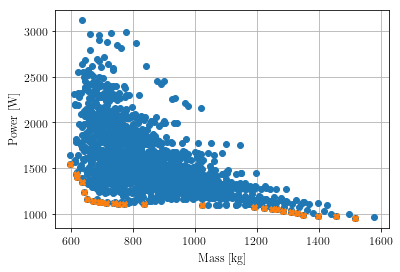

In [365]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
#plt.ylim(700,2000)
#plt.xlim(420,900)
#plt.savefig('Optimum.png',format = 'png', dpi=500,bbox_inches='tight')

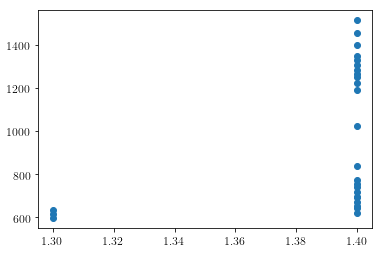

In [366]:
plt.plot(B_max_p,m_p,'o')

In [367]:
i = 0
Optimal(m_f_p[i]/3600,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i]+273.15,The_p[i]+273.15,L_xt_p[i])

(array([2901.55886901]),
 array([0.08059202]),
 array([0.26283473]),
 array([394.04584405]),
 array([187.87736907]),
 array([138.25183603]),
 array([32.4809592]),
 22.742948495336147,
 array([3785.14139209]),
 0.5,
 array([0.96315939]))

In [368]:
Q_c_new = [[] for i in range(len(m_p))]
m_flow_new = [[] for i in range(len(m_p))]


for i in range(len(m_p)):
    m_flow = np.arange(m_f_p[i]+5,1000,5)
    #print(m_f_p[i])
    for j in range(len(m_flow)):
        A = Optimal(m_flow[j]/3600,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i]+273.15,The_p[i]+273.15,L_xt_p[i])
        #print(m_flow[j],A[0],i,j,FE_p[i],f_p[i],L_p[i],H_p[i],W_p[i],B_max_p[i],22+273.15,35+273.15,Tce_p[i],The_p[i],L_xt_p[i])
        Q_c_new[i].append(A[0])
        m_flow_new[i].append(m_flow[j])

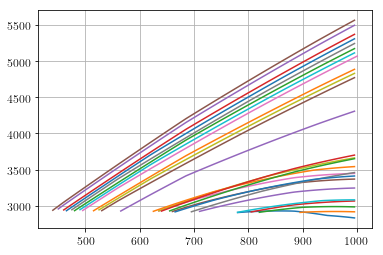

In [369]:
for i in range(len(m_p)):
    plt.plot(m_flow_new[i],Q_c_new[i])
#plt.ylim(2500,4000)
plt.grid()

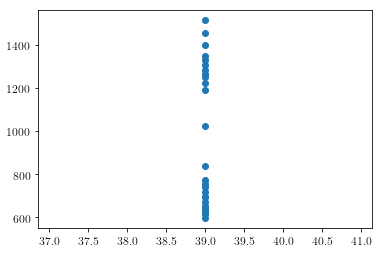

In [370]:
plt.plot(The_p,m_p,'o')

In [ ]:
m_3500_100= m_p
W_3500_100 = W_pa

In [ ]:
plt.plot(R4_p,'o')

In [ ]:
#plt.plot(m_2900,W_2900,'o', label = '$\dot{Q}_\mathrm{C}$ = 2900 W')
#plt.plot(m_3100,W_3100,'o', label = '$\dot{Q}_\mathrm{C}$ = 3100 W')
#plt.plot(m_3300,W_3300,'o', label = '$\dot{Q}_\mathrm{C}$ = 3300 W')
plt.plot(m_3500_100,W_3500_100,'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
plt.plot(m_3500,W_3500,'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
#plt.plot(m_2900_2,W_2900_2,'x', label = '$\dot{Q}_\mathrm{C}$ = 2900 W')
#plt.plot(m_3300_2,W_3300_2,'x', label = '$\dot{Q}_\mathrm{C}$ = 3300 W')
#plt.plot(m_3500_2,W_3500_2,'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
#plt.plot(m_3500_3,W_3500_3,'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
#plt.plot(m_3500_5,W_3500_5,'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
#plt.plot(m_3500_10,W_3500_10,'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
#plt.plot(m_L160,W_L160,'o', label = 'L = 160 mm')
#plt.plot(m_L180,W_L180,'o', label = 'W = 180 mm')

plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
#plt.legend()
plt.savefig('Power_Qc.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(m_2900,2900/np.array(W_2900),'o', label = '$\dot{Q}_\mathrm{C}$ = 2900 W')
plt.plot(m_3100,3100/np.array(W_3100),'o', label = '$\dot{Q}_\mathrm{C}$ = 3100 W')
plt.plot(m_3300,3300/np.array(W_3300),'o', label = '$\dot{Q}_\mathrm{C}$ = 3300 W')
plt.plot(m_3500,3500/np.array(W_3500),'o', label = '$\dot{Q}_\mathrm{C}$ = 3500 W')
#plt.plot(m_L160,W_L160,'o', label = 'L = 160 mm')
#plt.plot(m_L180,W_L180,'o', label = 'W = 180 mm')

plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('COP [-]')
plt.legend()
plt.savefig('COP_Qc.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
#plt.xlim([500,700])
#plt.ylim([1000,2500])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.savefig('Optimum_zoom_1Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
dP_AMR = np.array(W_pump)/(np.array(m_f_target)/3600)*1000

In [ ]:
plt.semilogy(m_p,np.array(W_p_CHEx_p)/np.array(W_pa),'o',label = 'CHEx - In')
plt.semilogy(m_p,np.array(W_p_CHEx_f)/np.array(W_pa),'o',label = 'CHEx - Out')
plt.semilogy(m_p,np.array(W_p_HHEx_p)/np.array(W_pa),'o',label = 'HHEx - In')
plt.semilogy(m_p,np.array(W_p_HHEx_f)/np.array(W_pa),'o',label = 'HHEx - Out')
plt.semilogy(m_p,np.array(W_p_mag)/np.array(W_pa),'o',label = 'AMR - Magnetic')
plt.semilogy(m_p,np.array(W_p_pump)/np.array(W_pa),'o',label = 'AMR - Pumping')
plt.semilogy(m_p,np.array(W_pa_valve)/np.array(W_pa),'o',label = 'Valve - Actuation')
plt.semilogy(m_p,np.array(W_pa_p_valve)/np.array(W_pa),'o',label = 'Valve - Pumping')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [$\%$]')
plt.legend()
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
workbook = xlsxwriter.Workbook('Optimization_results_1Hz.xlsx')
Data = workbook.add_worksheet('Data')

for i in range(len(m_f_p)):
    Data.write(i,0,m_f_p[i]) 
    Data.write(i,1,FE_p[i])
    Data.write(i,2,f_p[i])
    Data.write(i,3,L_p[i])
    Data.write(i,4,H_p[i])
    Data.write(i,5,W_p[i]) 
    Data.write(i,6,B_max_p[i])
    Data.write(i,7,Tce_p[i])
    Data.write(i,8,The_p[i])
    Data.write(i,9,m_p[i])
    Data.write(i,10,m_Nd_p[i])
    Data.write(i,11,m_La_p[i])
    Data.write(i,12,m_w_p[i])
    Data.write(i,13,W_pa[i])
    Data.write(i,14,W_p_CHEx_p[i])
    Data.write(i,15,W_p_CHEx_f[i])
    Data.write(i,16,W_p_HHEx_p[i])
    Data.write(i,17,W_p_HHEx_f[i])
    Data.write(i,18,W_p_mag[i])
    Data.write(i,19,W_p_pump[i])
    Data.write(i,20,R2_p[i])
    Data.write(i,21,R3_p[i])
    Data.write(i,22,R4_p[i])
    

workbook.close()

In [ ]:
A = W_p_CHEx_f +W_p_CHEx_p
plt.plot(W_p_mag,'o')

In [272]:
W_pa,m_f_p

([507.78610278922605,
  591.9783770177006,
  545.7771613697851,
  542.8198598988221,
  627.9905309807529,
  583.6794978294738,
  612.3599554020502,
  573.8855089769123,
  642.3844868992978,
  624.4080268048907,
  683.5528976435717,
  664.4887359740713,
  701.081650980314,
  745.7941792708092,
  684.6513439344293,
  722.156332520969,
  768.0258076372495,
  1014.9964700293569,
  762.3713545832586,
  927.9517949053047,
  828.9257855978491,
  791.044778489468,
  1644.442100742735,
  1050.9047845946395,
  1024.791920992807,
  834.3687922336078,
  879.6808926357965,
  775.6031586884584,
  835.2111207075427,
  802.1590226045371],
 [755.0,
  705.0,
  740.0,
  785.0,
  690.0,
  720.0,
  755.0,
  785.0,
  650.0,
  705.0,
  640.0,
  685.0,
  665.0,
  645.0,
  650.0,
  630.0,
  615.0,
  605.0,
  615.0,
  645.0,
  670.0,
  640.0,
  615.0,
  610.0,
  600.0,
  605.0,
  600.0,
  610.0,
  625.0,
  600.0])

In [273]:
len(W_p_valve)

9976

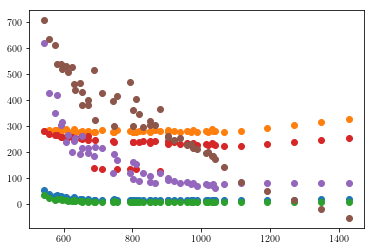

In [206]:
plt.plot(m_p,W_p_CHEx_p,'o')
plt.plot(m_p,W_p_CHEx_f,'o')
plt.plot(m_p,W_p_HHEx_p,'o')
plt.plot(m_p,W_p_HHEx_f,'o')
plt.plot(m_p,W_p_pump,'o')
plt.plot(m_p,W_p_mag,'o')

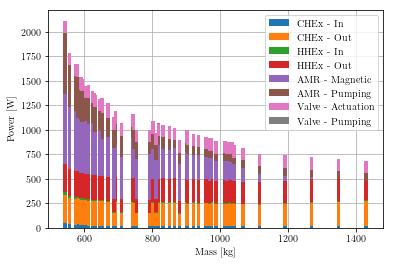

In [207]:
width = 10
plt.grid(zorder = 0)
plt.bar(m_p,W_p_CHEx_p, width, label = 'CHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = W_p_CHEx_p, label = 'CHEx - Out',zorder = 3)
plt.bar(m_p,W_p_HHEx_p, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f), label = 'HHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p), label = 'HHEx - Out',zorder = 3)
plt.bar(m_p,W_p_mag, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f), label = 'AMR - Magnetic',zorder = 3)
plt.bar(m_p,W_p_pump, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) , label = 'AMR - Pumping',zorder = 3)
plt.bar(m_p,W_pa_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f) + np.array(W_p_mag) + np.array(W_p_pump) , label = 'Valve - Actuation',zorder = 3)
plt.bar(m_p,W_pa_p_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) + np.array(W_p_pump)+ np.array(W_pa_valve), label = 'Valve - Pumping',zorder = 3)

#plt.xlim([575,865])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend(bbox_to_anchor = (1,1))
#plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [208]:
len(L_p)

51

In [212]:
m_Rt_p = np.pi*((np.array(R4_p))**2-np.array(R3_p)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2
m_St_p = np.pi*((np.array(R2_p)**2))*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500
m_Fe_p_10 = np.pi*((np.array(R4_p)+10)**2-np.array(R4_p)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_20 = np.pi*((np.array(R4_p)+20)**2-(np.array(R4_p)+10)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_40 = np.pi*((np.array(R4_p)+40)**2-(np.array(R4_p)+20)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_80 = np.pi*((np.array(R4_p)+80)**2-(np.array(R4_p)+40)**2)*10**-6*((1+np.array(L_xt_p))*np.array(L_p)/1000)*7500 #25**2 

In [210]:
L_p

[120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 130,
 130,
 130,
 140,
 150,
 150,
 150,
 150,
 150]

Text(0.5, 0, 'Power [W]')

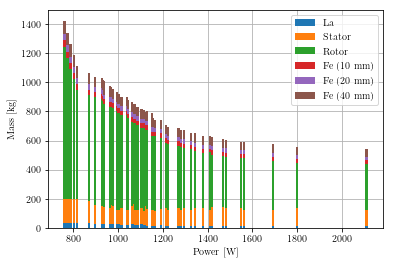

In [213]:
width = 10
plt.grid(zorder = 0)
plt.bar(W_pa,m_La_p, width, label = 'La',zorder = 3)
plt.bar(W_pa,m_St_p, width,bottom = m_La_p, label = 'Stator',zorder = 3)
plt.bar(W_pa,m_Rt_p, width,bottom = np.array(m_La_p) + np.array(m_St_p), label = 'Rotor',zorder = 3)
plt.bar(W_pa,m_Fe_p_10, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p), label = 'Fe (10 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_20, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10), label = 'Fe (20 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_40, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20), label = 'Fe (40 mm)',zorder = 3)
#plt.bar(W_pa,m_Fe_p_80, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20)+ np.array(m_Fe_p_40), label = 'Fe (80 mm)',zorder = 3)
plt.legend( bbox_to_anchor=[1, 1])
plt.ylabel('Mass [kg]')
plt.xlabel('Power [W]')
#plt.xlim(870,1300)
#plt.ylim(0,1050)
#plt.savefig('Mass_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

array([210.96606473, 209.23671081, 210.24357867, 232.73361722,
       231.5602607 , 233.30933577, 254.43787597, 256.94757966,
       277.88137373, 277.86120317, 301.24571059, 301.82232328,
       237.77764433, 236.42277961, 238.07411002, 261.69292436,
       260.94891535, 286.20177613, 342.34948241, 286.08378413,
       336.96486405, 367.04804164, 380.97055227, 327.03508139,
       392.19267921, 356.4510585 , 422.66362891, 401.75357176,
       434.2986533 , 349.51444863, 424.02552755, 367.5298195 ,
       447.37520275, 368.97306187, 444.10901713, 386.42232878,
       466.73075721, 451.41957484, 490.51169827, 451.87034598,
       472.53420861, 494.34044612, 467.20503116, 489.60638696,
       468.79855475, 485.11040914, 501.91799535, 549.0485839 ,
       597.34894282, 646.80143589, 697.38934412])

In [484]:
m_p,W_pa

([367.402400861069,
  398.345315962042,
  372.8456526475824,
  402.40845718959457,
  433.830910242989,
  467.02856121440635,
  382.8696921207481,
  387.6283174724972,
  410.5044001166666,
  440.2885452611251,
  472.0598790129393,
  505.7040746062123,
  400.2483965202077,
  423.9106349157607,
  451.37742090347405,
  481.2053589737194,
  477.6182089834999,
  466.057065809478,
  484.53539684062144,
  550.3606815764064],
 [1396.2981884921105,
  1067.4647171932024,
  1144.6335372320443,
  962.0860495912351,
  868.9929801223235,
  807.1608771280028,
  1098.4567484250542,
  1077.1504704109616,
  925.5806000591259,
  827.8488879621299,
  796.8268121007104,
  791.5180958874895,
  1062.7096565075608,
  914.3054675665245,
  817.6301261699194,
  791.6362740539375,
  nan,
  nan,
  nan,
  nan])

In [435]:
len(W_pa)

18

ValueError: x and y must have same first dimension, but have shapes (670,) and (216, 1)

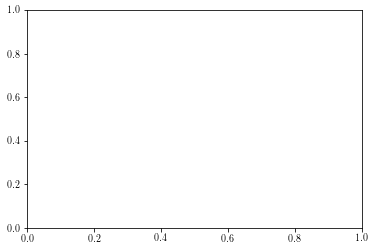

In [44]:
erro_Qc = np.arange(-100,250)
plt.plot(Q_c,np.array(Qc_rg)/16,'o')
plt.plot(erro_Qc,1.1*erro_Qc,'k--')
plt.plot(erro_Qc,0.9*erro_Qc,'k--')
plt.grid()
plt.ylabel('Analytical Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
plt.xlim(100,250)
plt.ylim(100,250)
plt.savefig('Qc_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Qh = np.arange(-100,350)
plt.plot(Q_h,np.array(Qh_rg)/16,'o')
plt.plot(erro_Qh,1.1*erro_Qh,'k--')
plt.plot(erro_Qh,0.9*erro_Qh,'k--')
plt.grid()
plt.ylabel('Analytical Rejected Heat [W]')
plt.xlabel('Numerical Rejected Heat [W]')
plt.xlim(120,300)
plt.ylim(120,300)
plt.savefig('Qh_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Wp = np.arange(0,25)
plt.plot(W_p,W_pump_rg,'o')

plt.plot(erro_Wp,1.1*erro_Wp,'k--')
plt.plot(erro_Wp,0.9*erro_Wp,'k--')
plt.grid()
plt.ylabel('Analytical Pumping Power [W]')
plt.xlabel('Numerical Pumping Power [W]')
#plt.xlim(120,300)
#plt.ylim(120,300)

### Closure Relations

In [ ]:
plt.plot(N_r,R4,'o')

In [ ]:
plt.plot(H,np.array(R3)-np.array(R2),'o')

Regenerator arranges